In [3]:
from datasets import load_dataset, concatenate_datasets, DatasetDict, load_from_disk

#datasets = load_dataset("swag", "regular")
datasets = load_from_disk("../swag.hf")
if False:
    # the labels for the test split are not public, therefore we create our own split
    # 60% train, 20% validation, 20% test
    merged_datasets = concatenate_datasets([datasets["train"], datasets["validation"]])
    
    train_testvalid = merged_datasets.train_test_split(test_size=0.4)
    # Split the 10% test + valid in half test, half valid
    test_valid = train_testvalid['test'].train_test_split(test_size=0.5)
    # gather everyone if you want to have a single DatasetDict
    datasets = DatasetDict({
        'train': train_testvalid['train'],
        'test': test_valid['test'],
        'validation': test_valid['train']})
else: 
    datasets
#datasets.save_to_disk("swag.hf"

In [4]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("answerdotai/ModernBERT-base")
#tokenizer.pad_token = tokenizer.eos_token  # Set padding token

In [5]:
import torch
import torch.nn as nn
from transformers import ModernBertModel

class ModernBERTForMultipleChoice(nn.Module):
    def __init__(self, model_name="answerdotai/ModernBERT-base"):
        super(ModernBERTForMultipleChoice, self).__init__()
        self.modernBERT = ModernBertModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(768, 1)
        nn.init.xavier_uniform(self.classifier.weight)
        self.loss_fct = nn.CrossEntropyLoss()

    def forward(self, input_ids, attention_mask=None, labels=None):
        bsz, num_choices, seq_len = input_ids.size()
        
        input_ids = input_ids.view(-1, seq_len)
        attention_mask = attention_mask.view(-1, seq_len)
        # Pass through BERT
        outputs = self.modernBERT(input_ids=input_ids, attention_mask=attention_mask)
        # Extract [CLS] token representation: (batch_size * 4, hidden_size)
        hidden_state = outputs.last_hidden_state  # (batch_size*num_choices, seq_len, hidden_size)
        pooled_output = hidden_state[:, -1, :]  # Last token representation

        logits = self.classifier(self.dropout(pooled_output))  # (batch_size*num_choices, 1)
        reshaped_logits = logits.view(bsz, num_choices)  # (batch_size, num_choices)
        
        # Compute loss if labels are provided
        loss = None
        if labels is not None:
            loss = self.loss_fct(reshaped_logits, labels)

        return {"loss": loss, "logits": reshaped_logits}

In [6]:
def preprocess_function(examples):
    first_sentences = [[context] * 4 for context in examples["sent1"]]
    question_headers = examples["sent2"]
    answer_choices = [examples[f"ending{i}"] for i in range(4)]

    second_sentences = [
        [f"{header} {choice}" for choice in choices]
        for header, choices in zip(question_headers, zip(*answer_choices))
    ]

    first_sentences = sum(first_sentences, [])
    second_sentences = sum(second_sentences, [])

    tokenized = tokenizer(
        first_sentences,
        second_sentences,
        truncation=True,
        padding="max_length",  # Ensure uniform sequence lengths
        max_length=128,        # Adjust based on GPU memory
        return_tensors="pt",
    )

    return {
        "input_ids": tokenized["input_ids"].view(-1, 4, tokenized["input_ids"].shape[-1]),
        "attention_mask": tokenized["attention_mask"].view(-1, 4, tokenized["attention_mask"].shape[-1]),
        "labels": examples["label"],
    }

encoded_dataset = datasets.map(preprocess_function, batched=True)

In [7]:
import numpy as np

def compute_metrics(eval_predictions):
    predictions, label_ids = eval_predictions
    preds = np.argmax(predictions, axis=1)
    return {"accuracy": (preds == label_ids).astype(np.float32).mean().item()}

In [8]:
from transformers import Trainer, TrainingArguments

# Initialize the model
model = ModernBERTForMultipleChoice("answerdotai/ModernBERT-base")

# Define training arguments
training_args = TrainingArguments(
    "modernBert-finetuned-swag",
    evaluation_strategy = "steps",
    eval_steps=1000,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    compute_metrics=compute_metrics,
)

# Start training
trainer.train()

/tmp/ipykernel_645/1168015417.py:11: FutureWarning: `nn.init.xavier_uniform` is now deprecated in favor of `nn.init.xavier_uniform_`.
  nn.init.xavier_uniform(self.classifier.weight)
/home/e12117772/2024W-DLNLP-BERT/.venv/lib/python3.11/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/home/e12117772/2024W-DLNLP-BERT/.venv/lib/python3.11/site-packages/torch/_inductor/compile_fx.py:167: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
1000,0.767800,0.707804,0.726991
2000,0.655000,0.653272,0.751577
3000,0.629700,0.614557,0.765152
4000,0.350900,0.677989,0.767237
5000,0.338200,0.643564,0.769963
6000,0.327400,0.722032,0.777338
7000,0.324900,0.671121,0.778247
8000,0.093200,1.629721,0.773169
9000,0.114400,1.660130,0.773811
10000,0.109600,1.702085,0.777659


TrainOutput(global_step=10527, training_loss=0.38127829422239135, metrics={'train_runtime': 6397.9466, 'train_samples_per_second': 26.32, 'train_steps_per_second': 1.645, 'total_flos': 0.0, 'train_loss': 0.38127829422239135, 'epoch': 3.0})

In [9]:
evaluated = trainer.evaluate()
evaluated

{'eval_loss': 1.7274415493011475,
 'eval_accuracy': 0.7773383259773254,
 'eval_runtime': 178.2216,
 'eval_samples_per_second': 104.982,
 'eval_steps_per_second': 6.565,
 'epoch': 3.0}

In [10]:
import pandas as pd
training_history_modernBert = pd.DataFrame(trainer.state.log_history)
training_history_modernBert.epoch = training_history_modernBert.epoch.astype(int)
training_history_modernBert.groupby("epoch").first()

,loss,grad_norm,learning_rate,step,eval_loss,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
epoch,,,,,,,,,,,,,,
0,0.9602,14.584893,0.000019,500,0.707804,0.726991,180.6310,103.581,6.477,NaN,NaN,NaN,NaN,NaN
1,0.3509,10.756747,0.000012,4000,0.677989,0.767237,178.3410,104.911,6.560,NaN,NaN,NaN,NaN,NaN
2,0.0982,22.217213,0.000006,7500,1.629721,0.773169,178.3724,104.893,6.559,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,10527,1.727442,0.777338,178.2216,104.982,6.565,6397.9466,26.32,1.645,0.0,0.381278


In [11]:
test_pred = trainer.predict(encoded_dataset["test"])
test_pred.metrics

{'test_loss': 1.6357057094573975,
 'test_accuracy': 0.7796483635902405,
 'test_runtime': 178.271,
 'test_samples_per_second': 104.958,
 'test_steps_per_second': 6.563}

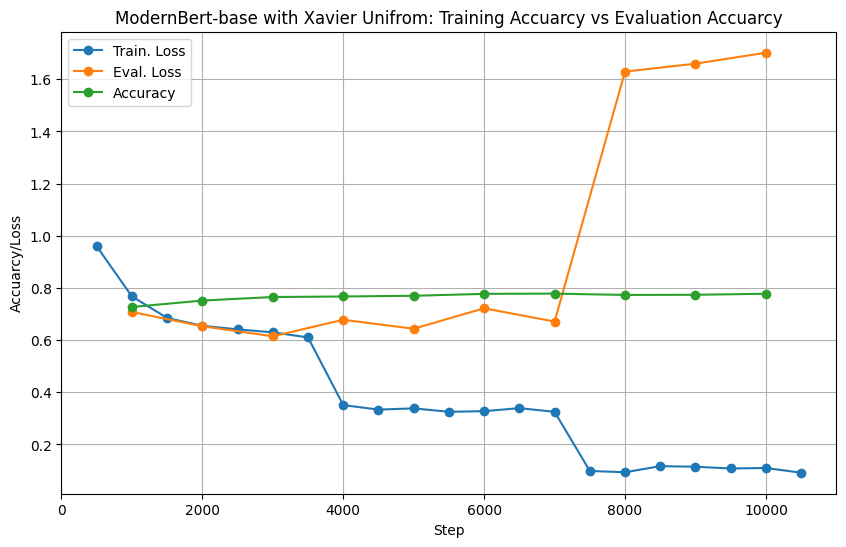

In [30]:
import matplotlib.pyplot as plt
import pandas as pd

# Prepare the data
data = training_history_modernBert[["loss", "eval_loss", "step", "eval_accuracy"]]
data.columns = ["Train. Loss", "Eval. Loss", "Training Steps", "Accuracy"]
data = data[:-1]  # drop last row
data = pd.melt(data, ['Training Steps']).dropna()

# Plot using Matplotlib
plt.figure(figsize=(10, 6))

# Plot each variable separately without using groupby
train_loss = data[data['variable'] == "Train. Loss"]
eval_loss = data[data['variable'] == "Eval. Loss"]
acc = data[data['variable'] == "Accuracy"]

plt.plot(train_loss["Training Steps"], train_loss["value"], marker='o', label="Train. Loss")
plt.plot(eval_loss["Training Steps"], eval_loss["value"], marker='o', label="Eval. Loss")
plt.plot(acc["Training Steps"], acc["value"], marker='o', label="Accuracy")

# Labels and Title
plt.ylabel('Accuarcy/Loss')
plt.xlabel('Step')
plt.title('ModernBert-base with Xavier Unifrom: Training Accuarcy vs Evaluation Accuarcy')
plt.legend()
plt.grid(True)

# Show plot
plt.savefig('ModernBert_swag_xavier_finetuned.png')

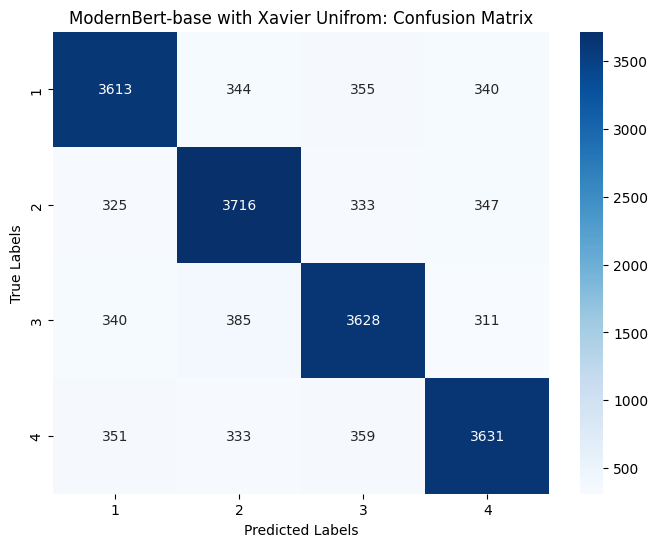

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

import evaluate

metric = evaluate.load("confusion_matrix")

predictions = np.argmax(test_pred.predictions, axis=-1)
metric.add_batch(predictions=predictions, references=datasets["test"]["label"])

# Compute confusion matrix
conf_matrix = metric.compute()['confusion_matrix']

# Define class labels manually (adjust as needed)
labels = ["1", "2", "3", "4"]

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('ModernBert-base with Xavier Unifrom: Confusion Matrix')
plt.savefig('swag_ModernBert_xavier_confusion_matrix.png')

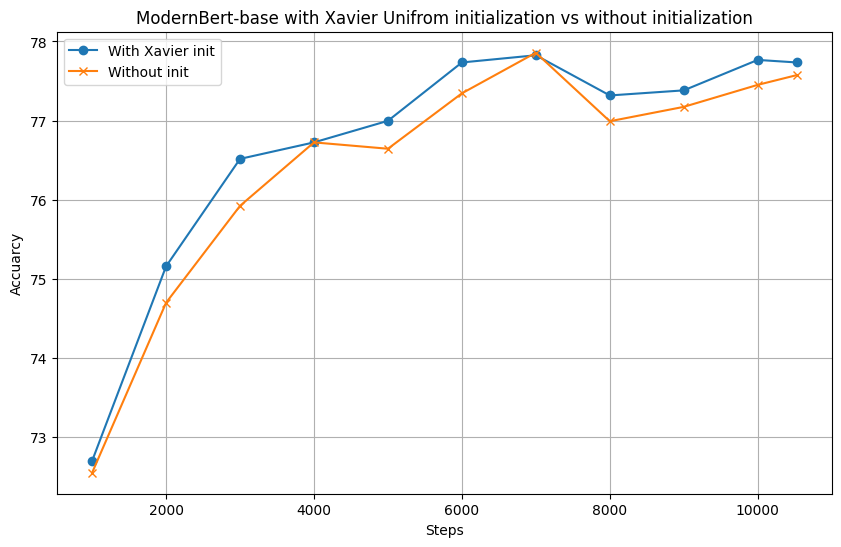

In [33]:
import matplotlib.pyplot as plt
import pandas as pd

acc_with_init = [0.726991, 0.751577, 0.765152, 0.767237, 0.769963, 0.777338, 0.778247, 0.773169, 0.773811, 0.777659, 0.7773383259773254]
acc_with_init = [x * 100 for x in acc_with_init]

acc_no_init = [0.725494, 0.746980, 0.759220, 0.767237, 0.766435, 0.773437, 0.778568, 0.769909, 0.771726, 0.774506, 0.7757349014282227]
acc_no_init = [x * 100 for x in acc_no_init]

steps = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000,9000, 10000, 10527]

# Plot using Matplotlib
plt.figure(figsize=(10, 6))


plt.plot(steps, acc_with_init, marker='o', label="With Xavier init")
plt.plot(steps, not_init, marker='x', label="Without init")


# Labels and Title
plt.ylabel('Accuarcy')
plt.xlabel('Steps')
plt.title('ModernBert-base with Xavier Unifrom initialization vs without initialization')
plt.legend()
plt.grid(True)

plt.savefig('ModernBert_swag_xavier_vs_no_finetuned.png')

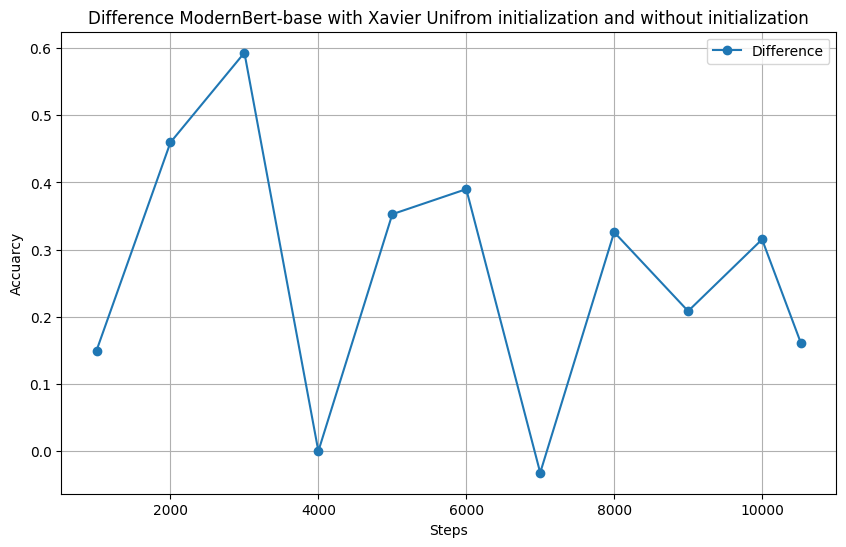

In [32]:
import matplotlib.pyplot as plt
import pandas as pd

acc_with_init = [0.726991, 0.751577, 0.765152, 0.767237, 0.769963, 0.777338, 0.778247, 0.773169, 0.773811, 0.777659, 0.7773383259773254]
acc_with_init = [x * 100 for x in acc_with_init]

acc_no_init = [0.725494, 0.746980, 0.759220, 0.767237, 0.766435, 0.773437, 0.778568, 0.769909, 0.771726, 0.774506, 0.7757349014282227]
acc_no_init = [x * 100 for x in acc_no_init]

diff = [x - y for x,y in zip(acc_with_init, acc_no_init)]
steps = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000,9000, 10000, 10527]

# Plot using Matplotlib
plt.figure(figsize=(10, 6))


plt.plot(steps, diff, marker='o', label="Difference")


# Labels and Title
plt.ylabel('Accuarcy')
plt.xlabel('Steps')
plt.title('Difference ModernBert-base with Xavier Unifrom initialization and without initialization')
plt.legend()
plt.grid(True)

plt.savefig('ModernBert_swag_diff_xavier_vs_no_finetuned.png')